In [1]:
models = {
    '1_point': 'vis_one_point.npy',
    'linear': 'vis_v4.npy',
    'clip_sam': 'vis_clip_sam_32.npy',
}

In [2]:
!cat ../../datasets/people_poses/val_id.short.txt

100034_483681
10005_205677
100142_449784
10014_1211482
10024_490664
100396_1228208
100409_439507
100428_475255
100434_223573
100439_194787
100564_202221
100678_1260457
100798_2205315
100909_1208726
100958_427612
100985_570554
101070_472538
101211_480925
10123_2152925
101354_2152170


In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
import cv2
import colorsys

N = 20
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
colors = list(RGB_tuples)
colors = [np.concatenate([colors[i], [0.45]]) for i in range(N)]

def get_layer(h, w):
    layer = np.ones((h, w, 4))
    layer[:,:,3] = 0
    return layer

img_dir = '../../datasets/people_poses/val_images'
gt_dir = '../../datasets/people_poses/val_segmentations'
image_layers = []
for one_image in open('../../datasets/people_poses/val_id.short.txt', 'r').readlines():
    one_image = one_image.strip()
    layers = {}
    image = cv2.imread(f'{img_dir}/{one_image}.jpg')
    h, w, _ = image.shape
    for model, vis_path in models.items():
        layer = get_layer(h, w)
        one_data = np.load(vis_path, allow_pickle=True).item()
        for one_mask in one_data[one_image]:
            layer[one_mask['segmentation']] = colors[one_mask['label']]
        layers[model] = layer
    layers['image'] = image[:,:,::-1]
    
    layer = get_layer(h, w)
    gt_mask = cv2.imread(f'{gt_dir}/{one_image}.png')[:,:,0]
    for i in range(N):
        layer[gt_mask == i] = colors[i]
    layers['gt'] = layer
    image_layers.append(layers)

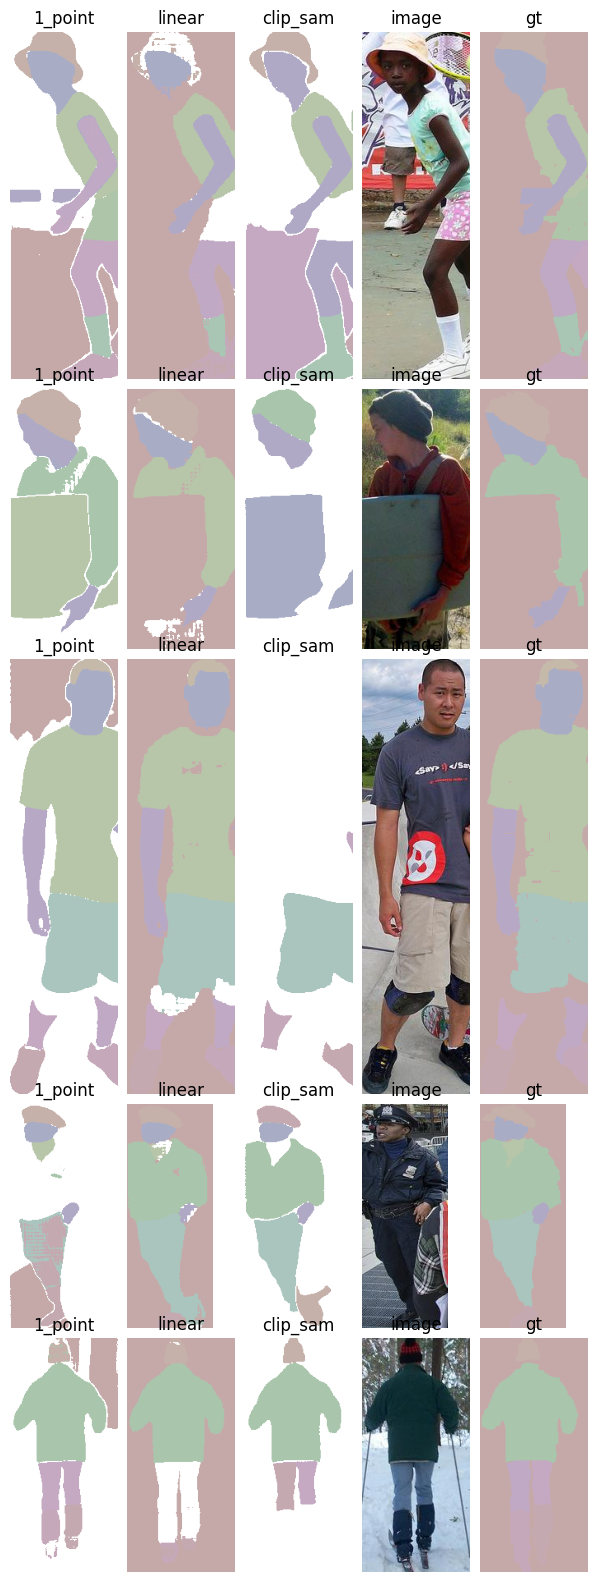

In [14]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

def layer_generator():
    for layers in image_layers:
        for layer in layers.items():
            yield layer

for ax, (model, im) in zip(grid, layer_generator()):
    ax.imshow(im)
    ax.set_title(model)
    ax.axis('off')

plt.savefig('output.png')
plt.show()